In [1]:
%matplotlib inline
import os
import sys
import typing as T
import itertools
import time

import meshcat
import crocoddyl
import numpy as np
import pinocchio
import pinocchio.visualize
import matplotlib.pyplot as plt
import mim_solvers

script_path = "/home/gepetto/ros2_ws/src/colmpc/examples"
if sys.path[0] != script_path:
    sys.path.insert(0, script_path)

from simulation import Simulation
from create_ocp import create_ocp_nocol
from param_parsers import ParamParser, argument_parser
from wrapper_panda import PandaWrapper

np.set_printoptions(linewidth=200)

# Setup
- Load a Panda robot.
- Create an OCP problem. The task is to reach an end-effector position.
- Generate an initial guess.

Mind the `shift_weights` function. It will be used later to shift left the weights of the reaching task at each simulation iteration. At the beginning, all the weights in the running nodes are equal and only the terminal node has a different weight.

In [2]:
robot_wrapper = PandaWrapper(capsule=False)
rmodel, cmodel, vmodel, = robot_wrapper()

goal_frame_id = rmodel.addFrame(
    pinocchio.Frame("goal", 0, 0, pinocchio.SE3.Identity(), pinocchio.FrameType.OP_FRAME)
)
tcp_frame_id = rmodel.getFrameId("panda2_hand_tcp")
rdata = rmodel.createData()

In [3]:
yaml_path = os.path.join(script_path, "scenes.yaml")
pp = ParamParser(yaml_path, 1)

rmodel.frames[goal_frame_id].placement = pp.get_target_pose()
ocp, objects = create_ocp_nocol(rmodel, pp)
ocp_weights = [ rm.differential.costs.costs["gripperPose"].weight for rm in ocp.problem.runningModels ]

def reset_weights(ocp):
    for rm, w in zip(ocp.problem.runningModels, ocp_weights):
        rm.differential.costs.costs["gripperPose"].weight = w

def shift_weights(ocp):
    p = ocp.problem
    for rm1, rm2 in itertools.pairwise(p.runningModels):
        rm1.differential.costs.costs["gripperPose"].weight = rm2.differential.costs.costs["gripperPose"].weight
    p.runningModels[-1].differential.costs.costs["gripperPose"].weight = p.terminalModel.differential.costs.costs["gripperPose"].weight

In [4]:
ocp.problem.nthreads = 6
if 0:
    ocp.setCallbacks([
        mim_solvers.CallbackLogger(),
        mim_solvers.CallbackVerbose(),
    ])
ocp.mu_dynamic = -1
ocp.mu_constraint = -1

XS_init = [pp.get_X0()] * (pp.get_T() + 1)
US_init = ocp.problem.quasiStatic(XS_init[:-1])

ocp.xs = XS_init.copy()
ocp.us = US_init.copy()

ok = ocp.solve(ocp.xs, ocp.us, 1000)
assert ok

# Build up simulation

We simulate the following setup. A low frequency MPC sends torque commands to a high frequency torque controller.

We aim at observing:
- the influence of a bad inertial model of the robot on the MPC control and
- the influence of the high frequency controller when the robot inertial model is not accurate.

The simulation works as follow:
- solve the OCP problem.
- apply the first control produced by the OCP using the high frequency controller.
- Read the new state, shift the previous OCP solution and shift the weights in the OCP cost function.

We consider two high frequency controllers. Both applies the control in `n_sim_steps` steps so that the high level frequency is `n_sim_steps` times the low frequency.
- basic HF controller: merely apply the OCP control result
- integral HF controller: correct the torque so as to match the position and velocity from OCP.

In [5]:
def create_simulation(
    rmodel: pinocchio.Model,
    vmodel: pinocchio.GeometryModel,
    name: str,
    x0: np.ndarray,
    world_shift: T.Optional[pinocchio.SE3] = None,
    dmasses: T.Optional[T.List[float]] = None,
    dcoms: T.Optional[T.List[np.ndarray]] = None,
    dinertias: T.Optional[T.List[np.ndarray]] = None,
    armature: T.Optional[np.ndarray] = None,
    n_sim_steps: int = 1,
    ) -> T.Tuple[Simulation, pinocchio.visualize.MeshcatVisualizer]:
    rmodel = rmodel.copy()
    vmodel = vmodel.copy()
    if world_shift is not None:
        for j in range(1, rmodel.njoints):
            if rmodel.parents[j] == 0:
                rmodel.jointPlacements[j] = world_shift * rmodel.jointPlacements[j]
        for j in range(1, rmodel.nframes):
            if rmodel.frames[j].parentJoint == 0:
                rmodel.frames[j].placement = world_shift * rmodel.frames[j].placement
        for j in range(1, vmodel.ngeoms):
            if vmodel.geometryObjects[j].parentJoint == 0:
                vmodel.geometryObjects[j].placement = world_shift * vmodel.geometryObjects[j].placement
    if dmasses is not None:
        assert len(dmasses) == rmodel.njoints
        for j in range(1, rmodel.njoints):
            rmodel.inertias[j].mass = rmodel.inertias[j].mass + dmasses[j]
            assert rmodel.inertias[j].mass > 0
    if dcoms is not None:
        assert len(dcoms) == rmodel.njoints
        for j in range(1, rmodel.njoints):
            rmodel.inertias[j].lever = rmodel.inertias[j].lever + dcoms[j]
    if dinertias is not None:
        assert len(dinertias) == rmodel.njoints
        for j in range(1, rmodel.njoints):
            rmodel.inertias[j].inertia = rmodel.inertias[j].intertia + dinertias[j]

    # Stat and actuation model
    state = crocoddyl.StateMultibody(rmodel)
    actuation = crocoddyl.ActuationModelFull(state)

    # Create Differential Action Model (DAM), i.e. continuous dynamics and cost functions
    cost_model = crocoddyl.CostModelSum(state)
    differential = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, cost_model)
    if armature is not None:
        differential.armature = armature
    integration = crocoddyl.IntegratedActionModelEuler(differential, pp.get_dt())

    simulation = Simulation(integration, pp.get_dt(), x0, n_sim_steps)


    viewer = pinocchio.visualize.MeshcatVisualizer(
        model=rmodel,
        collision_model=vmodel,
        visual_model=vmodel,
    )
    viewer.initViewer(open=False, viewer=meshcat_viewer)
    viewer.loadViewerModel(name)
    viewer.displayVisuals(True)
    viewer.displayFrames(True, [goal_frame_id, rmodel.getFrameId("panda2_hand_tcp"),])
    return simulation, viewer

In [6]:
meshcat_viewer = meshcat.Visualizer()
time.sleep(5)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [7]:
meshcat_viewer.jupyter_cell()

In [8]:
velocity_gain = 1000
position_gain = 1000
def low_level_control(x, xdes, u, dt):
    M = pinocchio.crba(rmodel, rdata, x[:rmodel.nq])
    dv = (xdes[rmodel.nq:] - x[rmodel.nq:])
    dq = (xdes[:rmodel.nq] - x[:rmodel.nq])
    Gv = velocity_gain # * np.exp(-np.linalg.norm(dv))
    Gq = position_gain # * np.exp(-np.linalg.norm(dq))
    da = Gv * dv + Gq * dq

    return u + M @ da
    # Clipping introduces some artifacts between the two high frequency controllers
    # so it is disabled for the purpose of this study.
    return np.clip(
        u + M @ da,
        -rmodel.effortLimit,
        rmodel.effortLimit,
    )

The lines below sets up 7 simulations.
The robot model used to simulate and the robot model used by OCP can vary. In this basic example, we add a mass (in kg) at the end effector.

| simulation index             | 0 | 1 | 2 | 3 | 4 | 5 | 6 |
|------------------------------|---|---|---|---|---|---|---|
| end effector additional mass | 0 | 1 | 1 | 2 | 2 | 3 | 3 |
| control                      | B | B | T | B | T | B | T |

On the control line, B stands for *basic HF controller* and T stands for the *tracker HF controller* (that tracks the OCP position and velocity)

In [9]:
n_sim_steps = 10
armature = 0.1 * np.ones(rmodel.nv)
simulations = [ create_simulation(rmodel, cmodel, name="sim", x0=pp.get_X0(), armature=armature) + ({"mass": -1, "low_level": False},) ]
masses = [ i.mass for i in rmodel.inertias ]
coms = [ i.lever for i in rmodel.inertias ]
for i in range(3): # number of mass variations
    for with_low_level in [ False, True ]:
        # dmasses = masses * (np.random.random(rmodel.njoints)-0.5) / 5 # in range -0.1kg, 0.1kg
        # print(dmasses)
        dmasses = np.zeros(rmodel.njoints)
        dmasses[-1] = (i+1) * 1
        # dmasses = None
        # dcoms = (np.random.random((rmodel.njoints,3))-0.5) / 5
        dcoms = None
        # print(dcoms)
        s, v = create_simulation(
            rmodel,
            cmodel,
            name=f"sim_{i}_{int(with_low_level)}",
            x0 = pp.get_X0(),
            world_shift = pinocchio.SE3(np.eye(3), len(simulations) * np.array([0, 0.5, 0])),
            dmasses=dmasses,
            dcoms=dcoms,
            dinertias=None,
            armature=armature,
            n_sim_steps=n_sim_steps,
        )
        if with_low_level:
            s.set_low_level_controller(low_level_control)
        simulations.append((s,v,{ "mass": i, "low_level": with_low_level}))

In [10]:
sim_results = []
def simulation_callback(i):
    shift_weights(ocp)
    
for i, (simulation, viewer, _) in enumerate(simulations):
    simulation: Simulation
    ocp.problem.x0 = pp.get_X0()
    traj = simulation.loop(ocp, XS_init.copy(), US_init.copy(), 200, iter_callback=simulation_callback)
    sim_results.append(traj)
    viewer.display(simulation.q)
    reset_weights(ocp)
    print("Simulation", i, "done")

Simulation 0 done
Simulation 1 done
Simulation 2 done
Simulation 3 done
Simulation 4 done
Simulation 5 done
Simulation 6 done


# Plot the positions, velocities and torques

The following lines plot the simulated trajectories. Dashed trajectories corresponds to cases using the tracking HF controller that tracks the OPC position and velocity.

In [11]:
trajs = np.array([r["states"] for r in sim_results])
ocp_controls = np.array([ r["ocp_controls"] for r in sim_results ])

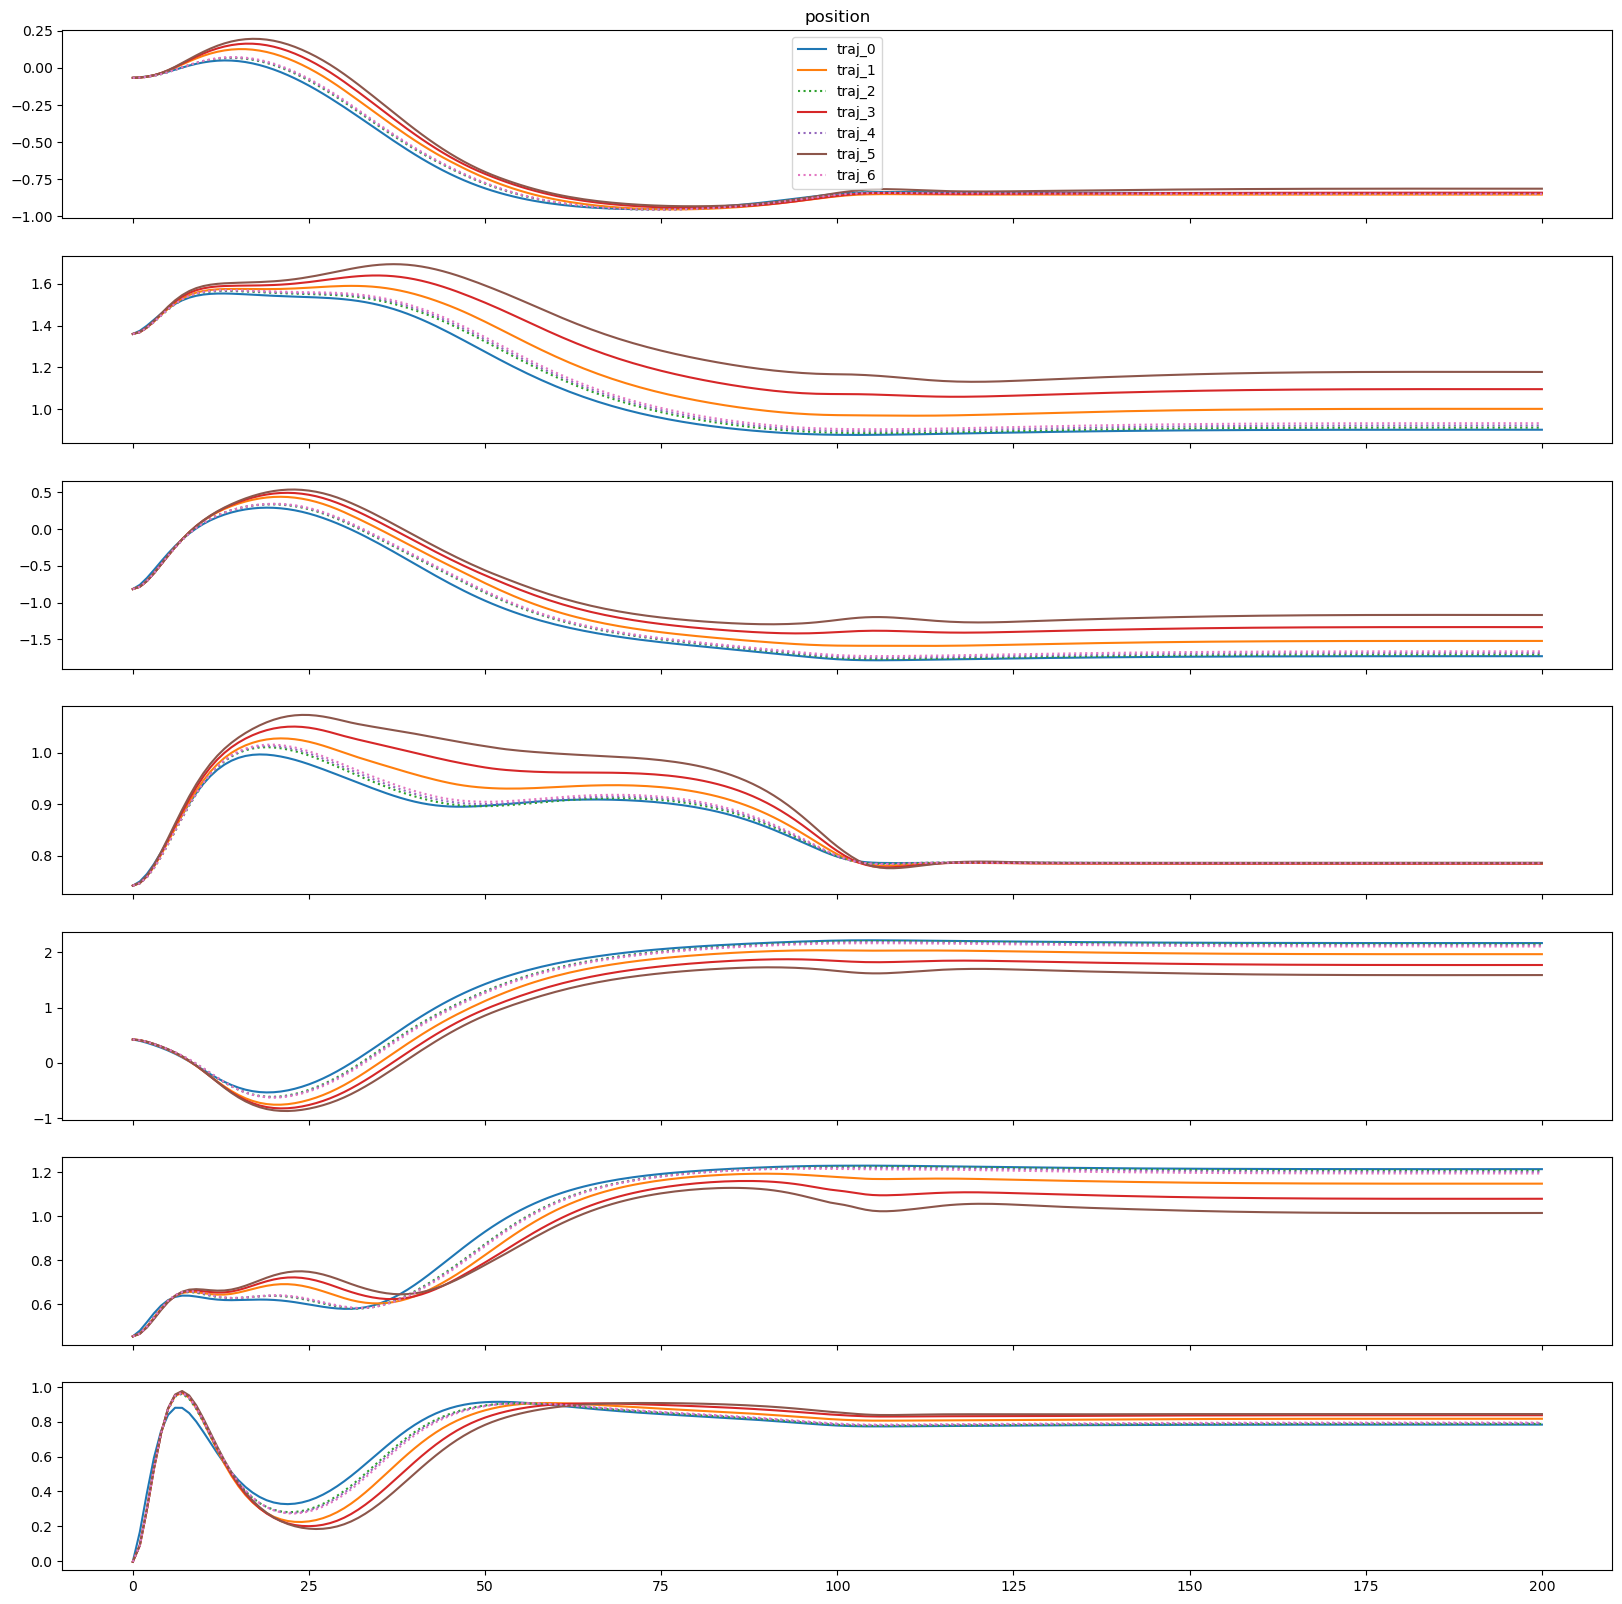

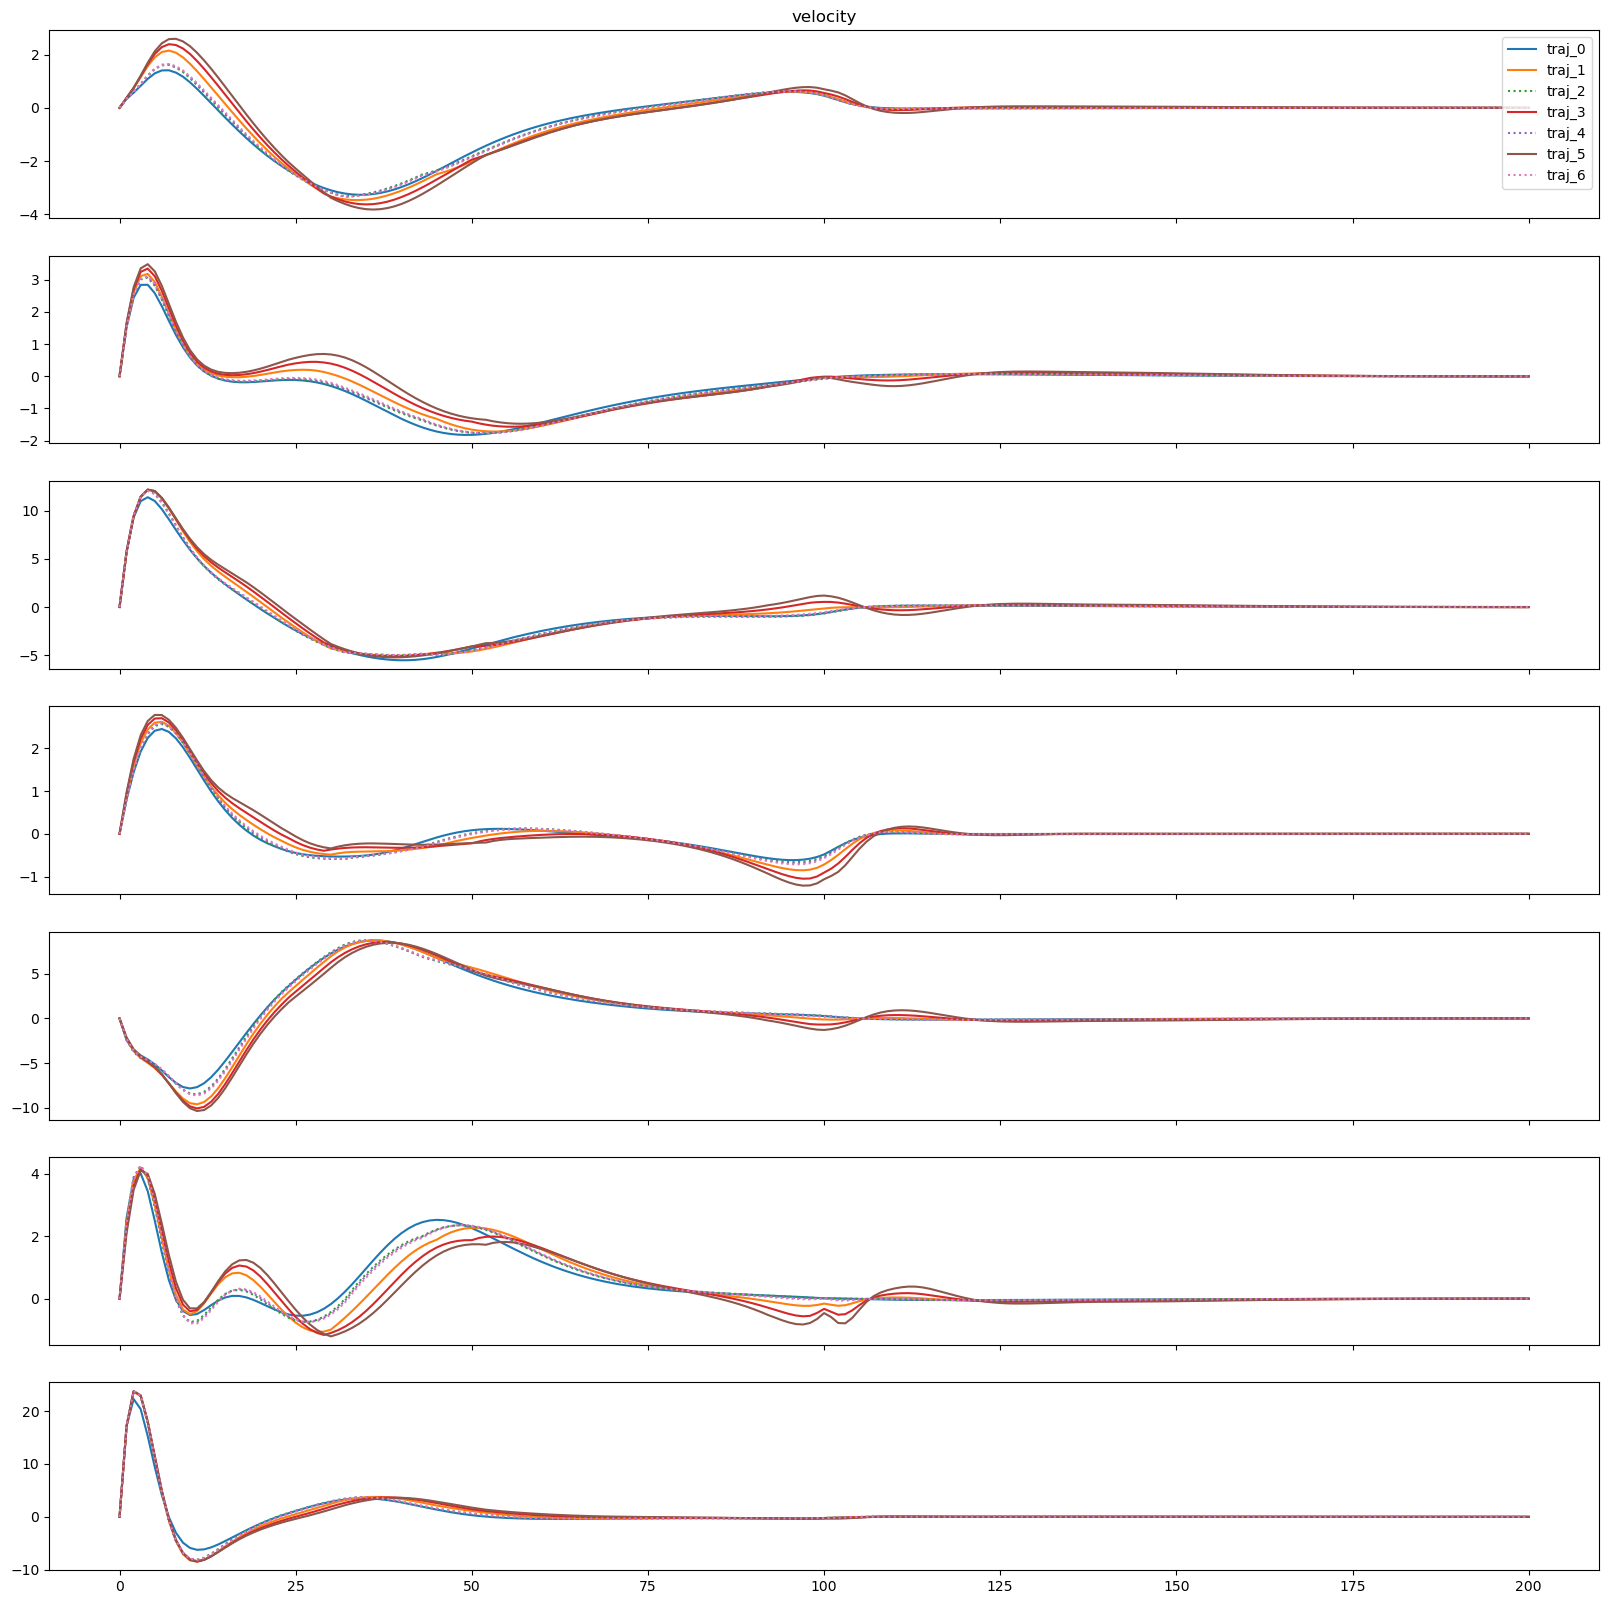

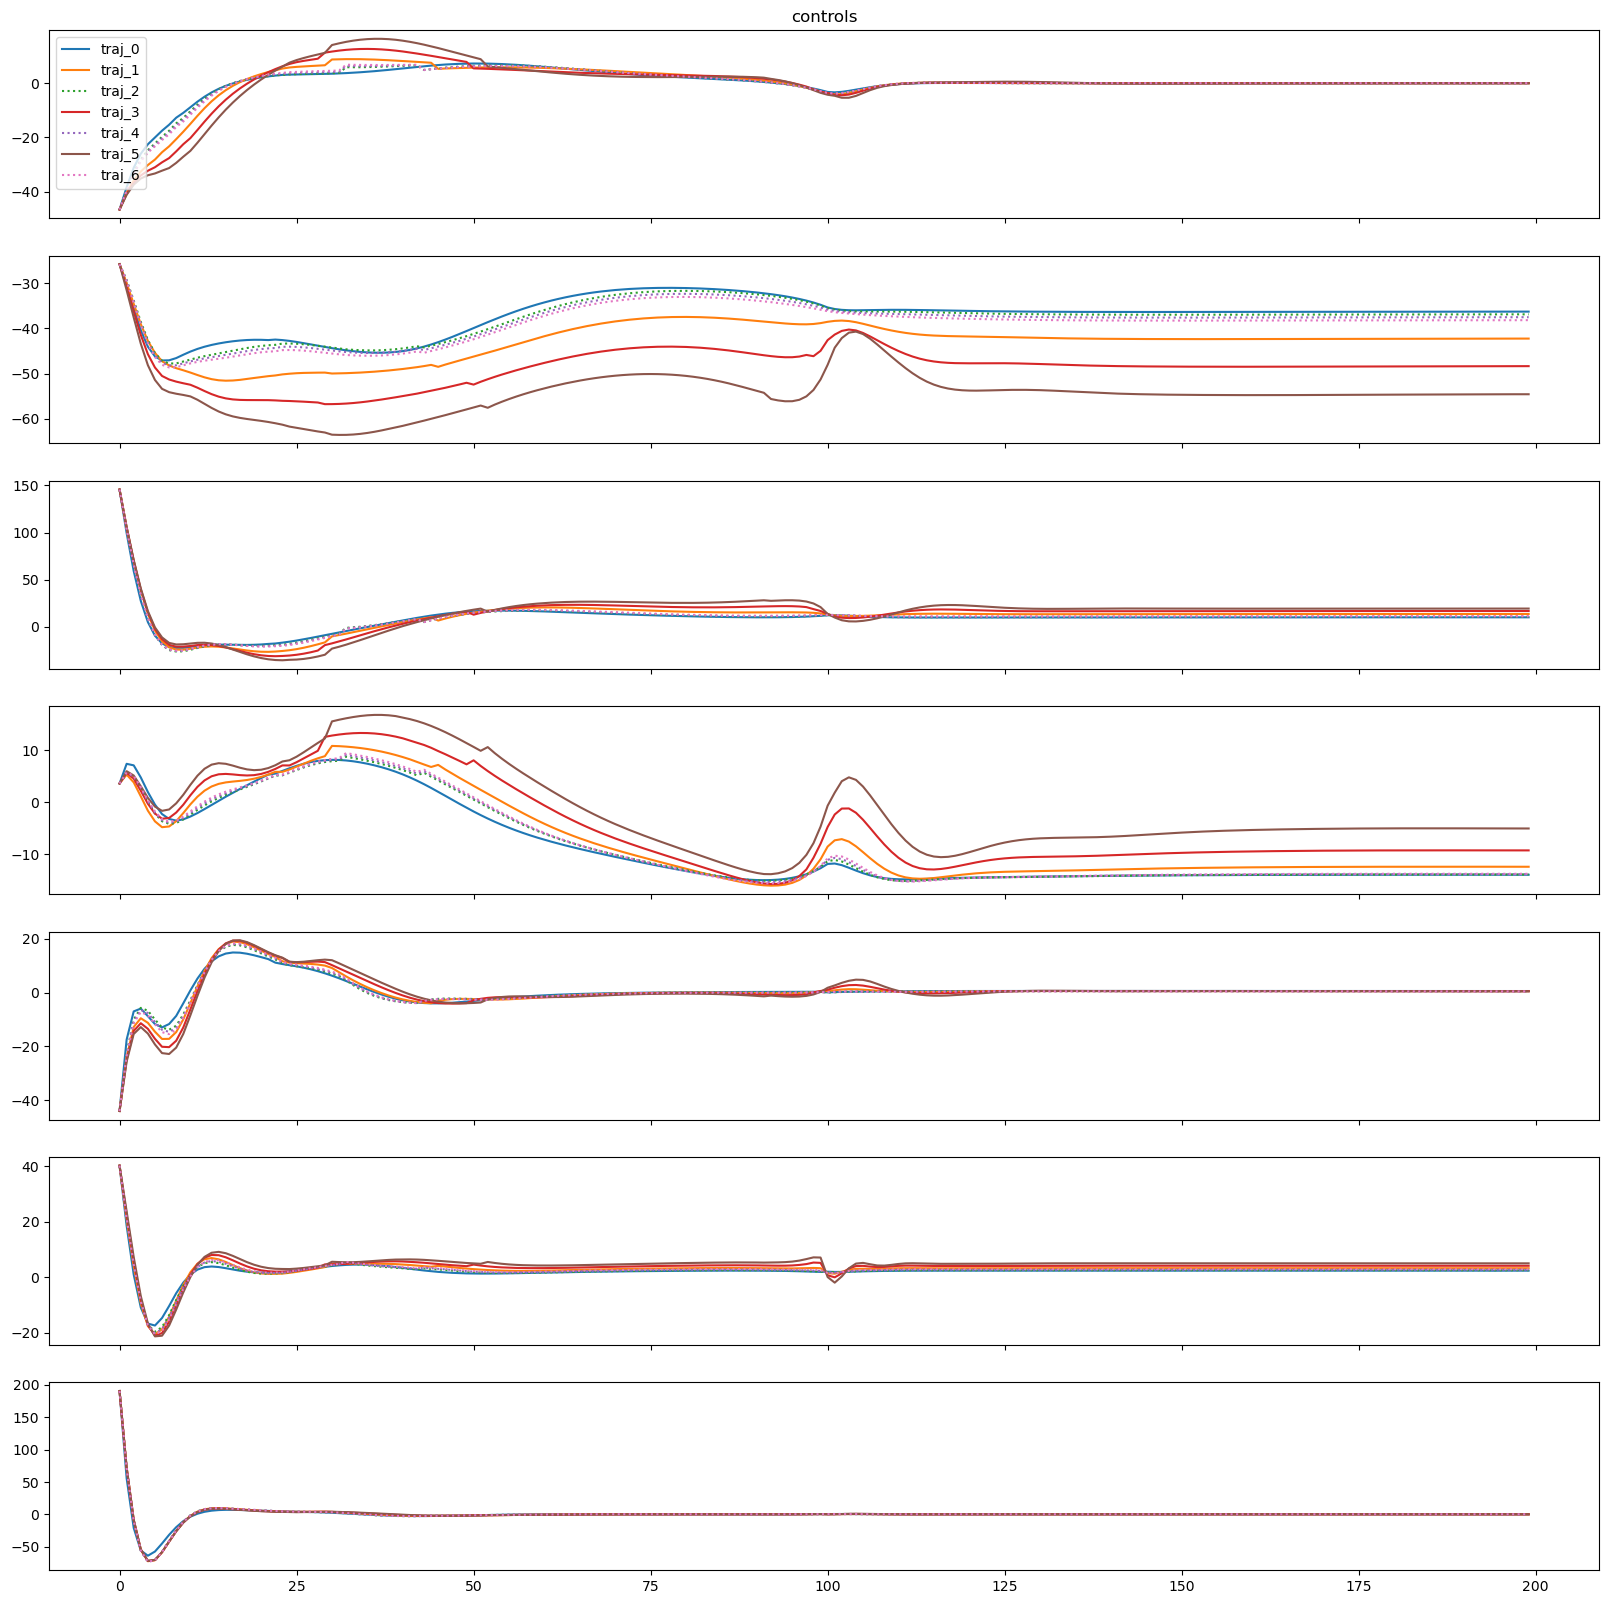

In [12]:
figq, axq = plt.subplots(rmodel.nq, 1, sharex=True)
figq.set_figwidth(20)
figq.set_figheight(20)
for k, ax in enumerate(axq):
    lines = ax.plot(trajs[:,:,k].T)
    for it, l in enumerate(lines):
        l.set_label(f"traj_{it}")
        if simulations[it][2]["low_level"]:
            l.set_linestyle(':')

axq[0].legend()
axq[0].set_title("position")

figv, axv = plt.subplots(rmodel.nv, 1, sharex=True)
figv.set_figwidth(20)
figv.set_figheight(20)
for k, ax in enumerate(axv):
    lines = ax.plot(trajs[:,:,rmodel.nq+k].T)
    for it, l in enumerate(lines):
        l.set_label(f"traj_{it}")
        if simulations[it][2]["low_level"]:
            l.set_linestyle(':')
axv[0].legend()
axv[0].set_title("velocity")

figt, axt = plt.subplots(rmodel.nv, 1, sharex=True)
figt.set_figwidth(20)
figt.set_figheight(20)
for k, ax in enumerate(axt):
    lines = ax.plot(ocp_controls[:,:,0,k].T)
    for it, l in enumerate(lines):
        l.set_label(f"traj_{it}")
        if simulations[it][2]["low_level"]:
            l.set_linestyle(':')
axt[0].legend()
axt[0].set_title("controls")

plt.show()

# Calculate and plot the residual error of the reaching task.

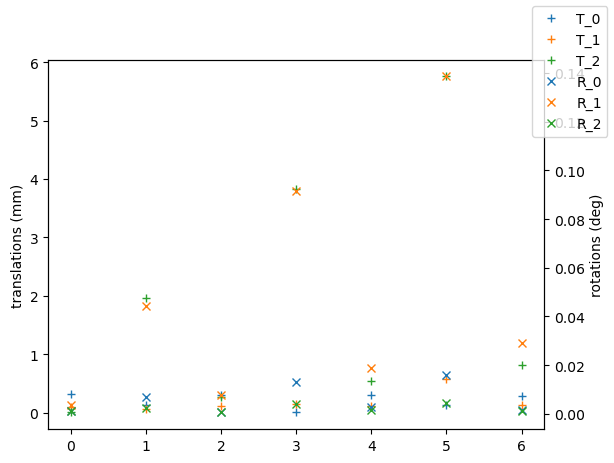

In [13]:
def get_target_error(q):
    pinocchio.forwardKinematics(rmodel, rdata, q)
    oMf = pinocchio.updateFramePlacement(rmodel, rdata, tcp_frame_id)
    oMg = pinocchio.updateFramePlacement(rmodel, rdata, goal_frame_id)
    e = pinocchio.log6(oMg.actInv(oMf)).vector
    return e

target_errors = np.array([ get_target_error(simulation.q) for simulation, _, _ in simulations ])

fige = plt.figure()
axpos = fige.gca()
axrot = axpos.twinx()
axpos.set_ylabel("translations (mm)")
axrot.set_ylabel("rotations (deg)")
lines = axpos.plot(np.abs(target_errors[:,:3]) / 1e-3, '+')
for it, l in enumerate(lines):
    l.set_label(f"T_{it}")
lines = axrot.plot(np.degrees(np.abs(target_errors[:,3:])), 'x')
for it, l in enumerate(lines):
    l.set_label(f"R_{it}")
fige.legend()

In [14]:
target_errors

array([[-3.20224968e-04, -9.47339709e-05,  1.00386519e-05, -2.09623583e-05,  6.25762342e-05,  1.68480374e-05],
       [-1.37056941e-04, -7.28300497e-05,  1.96835409e-03, -1.18562222e-04, -7.74577930e-04, -4.28355903e-05],
       [-3.11056620e-04, -1.07618094e-04,  2.74401048e-04,  1.10372720e-05, -1.31712968e-04, -9.76935348e-06],
       [-4.78062397e-06,  1.55583087e-04,  3.83643345e-03, -2.25274895e-04, -1.59493681e-03, -7.12304308e-05],
       [-3.03244901e-04, -1.20728987e-04,  5.45221845e-04,  4.61798094e-05, -3.31707972e-04, -2.67723014e-05],
       [ 1.39296495e-04,  5.85764816e-04,  5.75409678e-03, -2.81197404e-04, -2.41818958e-03, -8.05999029e-05],
       [-2.91401282e-04, -1.24504137e-04,  8.21459517e-04,  2.92555161e-05, -5.06584190e-04, -1.96868389e-05]])

# Compare how well MPC predicts the next state

We compare the state predicted by OCP for the first running node (i.e. `ocp.xs[1]`) and the state generated by the simulation after applying control computed by the OCP. 

Dashed trajectories corresponds to cases using the tracking HF controller that tracks the OPC position and velocity.

In [15]:
ocp_states = np.array([ r["ocp_states"] for r in sim_results ])
ocp_next_state_estimation = ocp_states[:,:,1,:]
measured_next_state = np.array([r["states"][1:] for r in sim_results])

assert ocp_next_state_estimation.shape == measured_next_state.shape

next_state_error = ocp_next_state_estimation-measured_next_state

Text(0.5, 1.0, 'velocity')

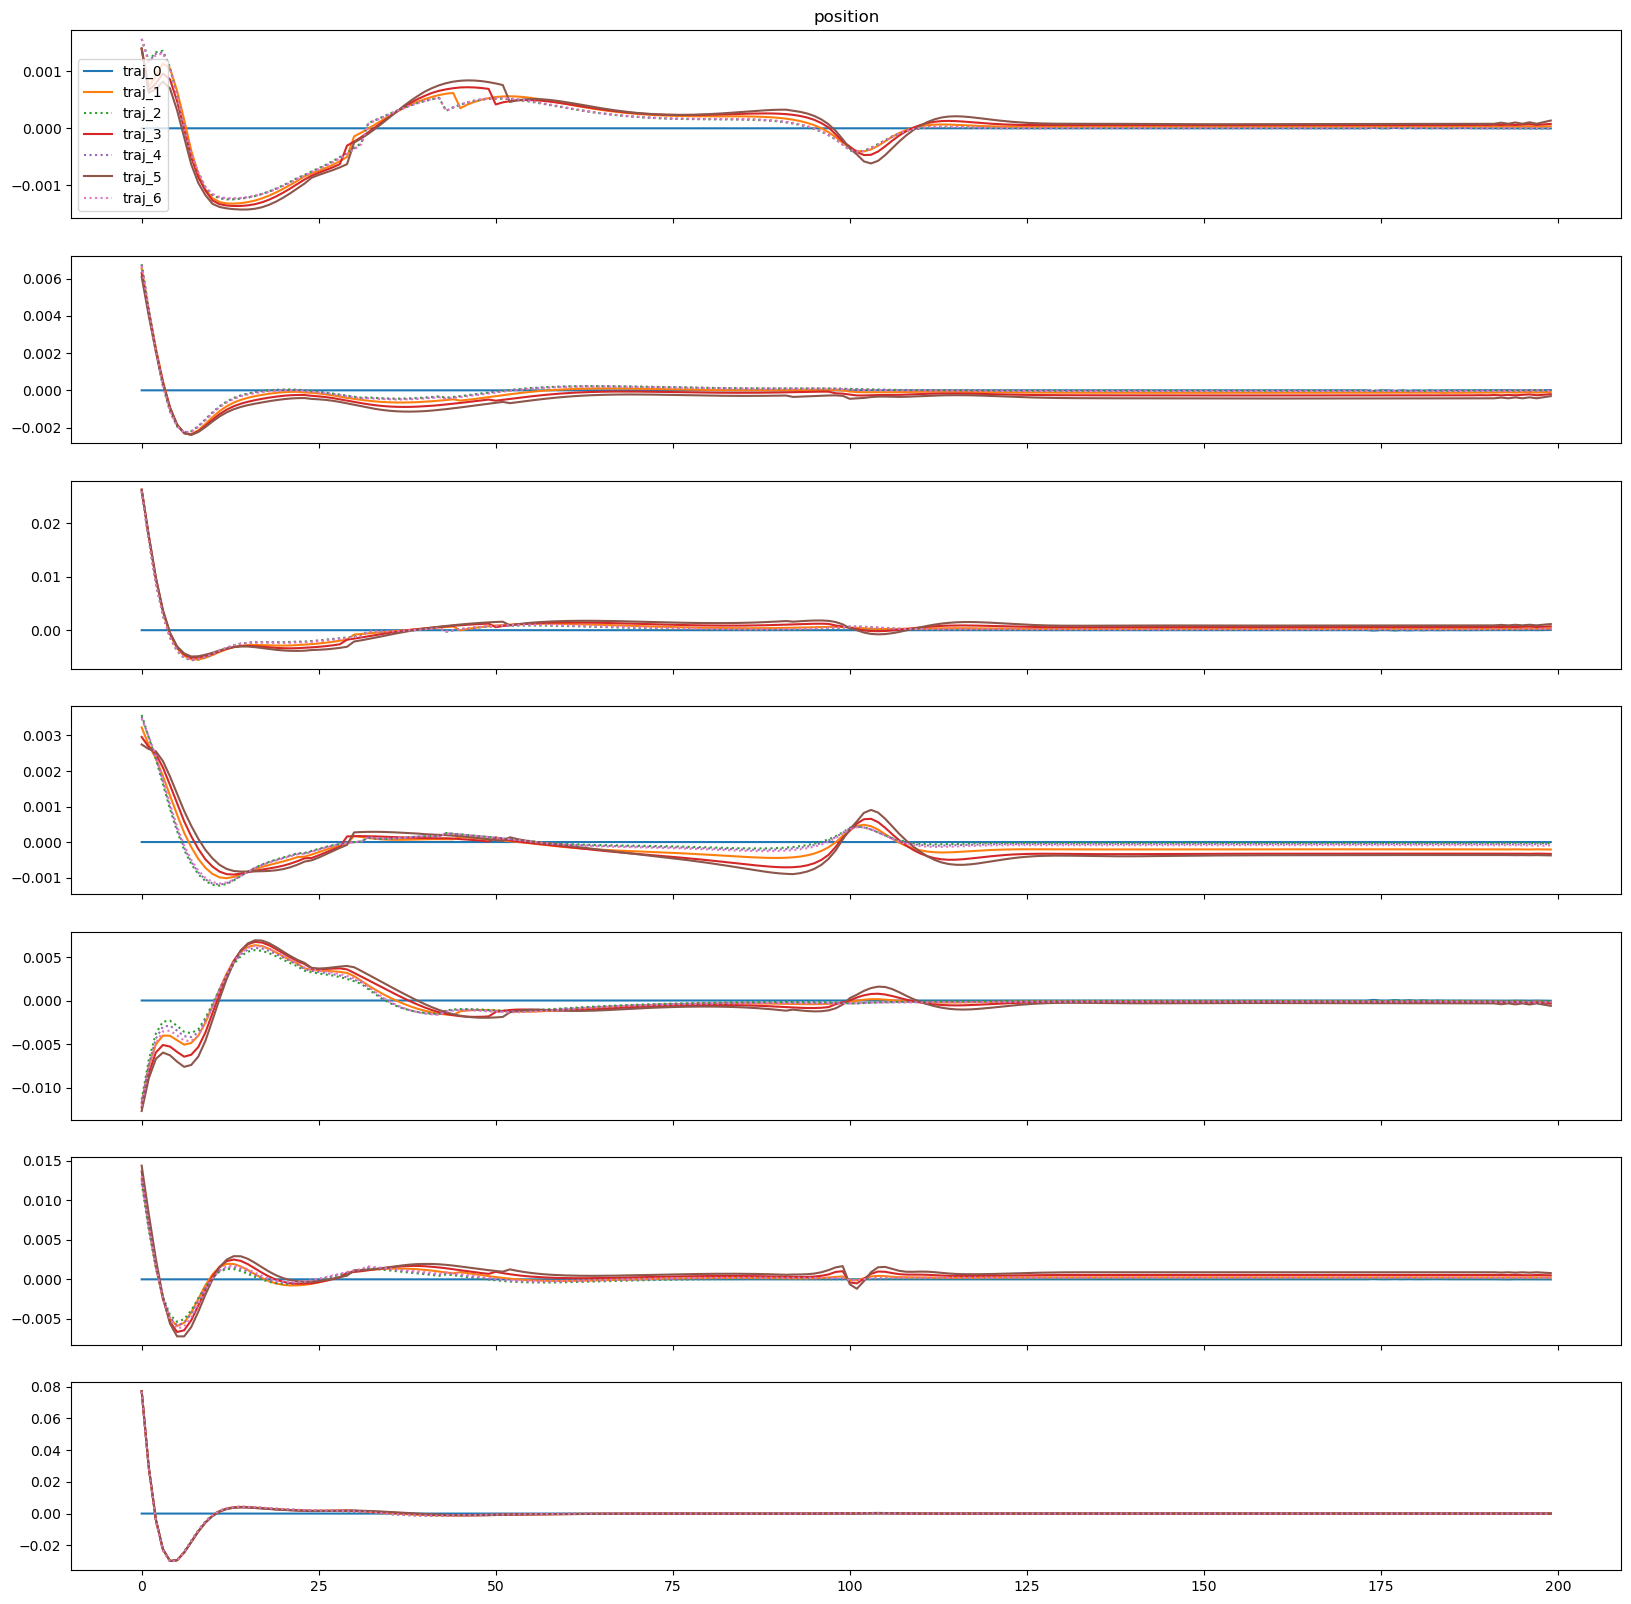

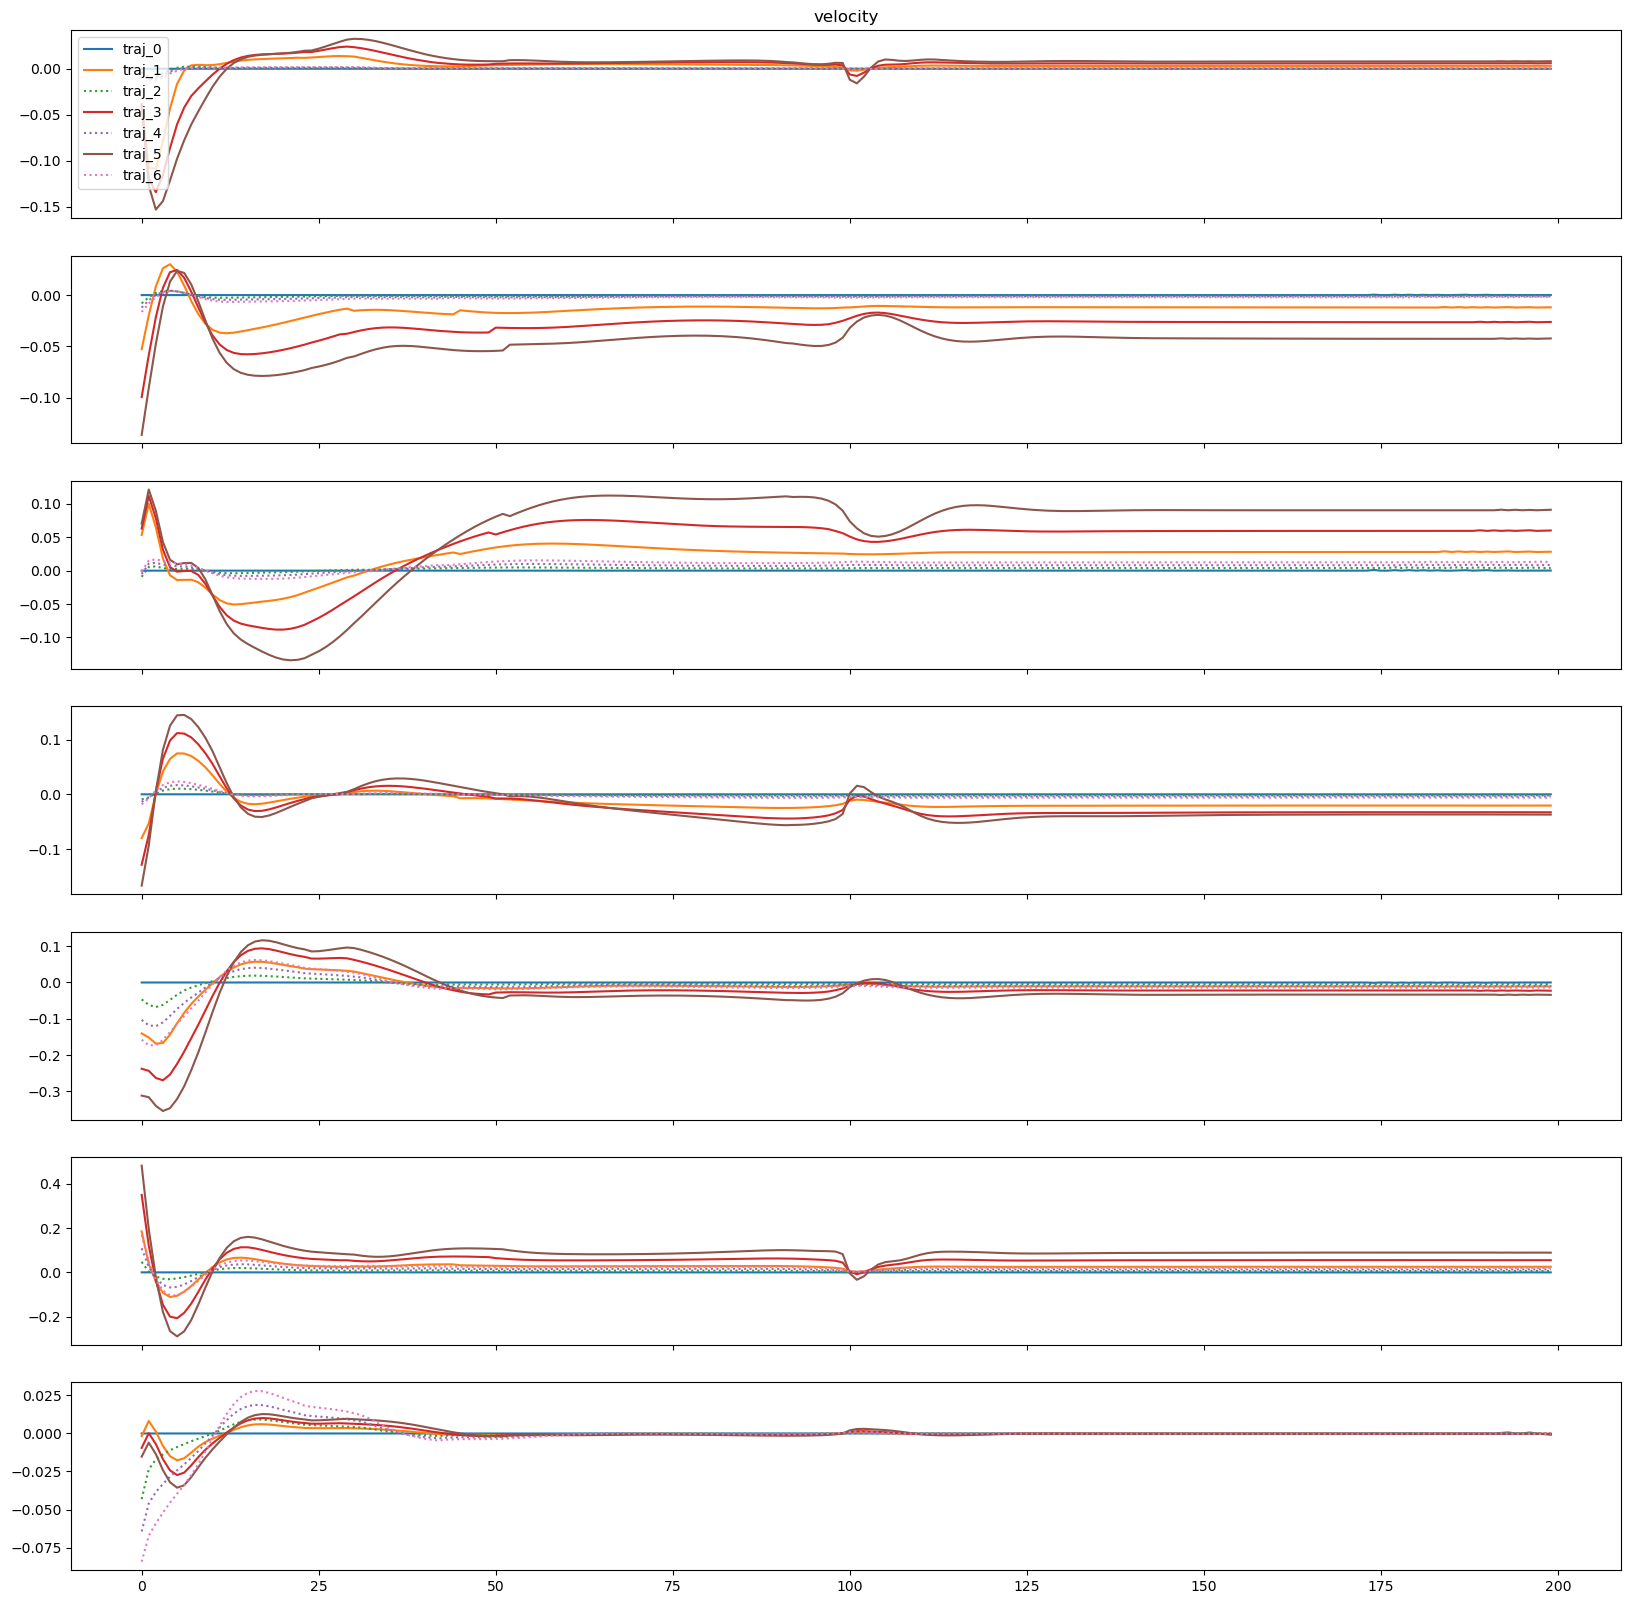

In [16]:
figq, axq = plt.subplots(rmodel.nq, 1, sharex=True)
figq.set_figwidth(20)
figq.set_figheight(20)
for k, ax in enumerate(axq):
    lines = ax.plot(next_state_error[:,:,k].T)
    for it, l in enumerate(lines):
        l.set_label(f"traj_{it}")
        if simulations[it][2]["low_level"]:
            l.set_linestyle(':')

axq[0].legend()
axq[0].set_title("position")

figv, axv = plt.subplots(rmodel.nv, 1, sharex=True)
figv.set_figwidth(20)
figv.set_figheight(20)
for k, ax in enumerate(axv):
    lines = ax.plot(next_state_error[:,:,rmodel.nq+k].T)
    for it, l in enumerate(lines):
        l.set_label(f"traj_{it}")
        if simulations[it][2]["low_level"]:
            l.set_linestyle(':')
axv[0].legend()
axv[0].set_title("velocity")